# Import libraries

In [1]:
from typing import List
from datetime import datetime as dt

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%run ./utils.ipynb

### Loading data from REMSS

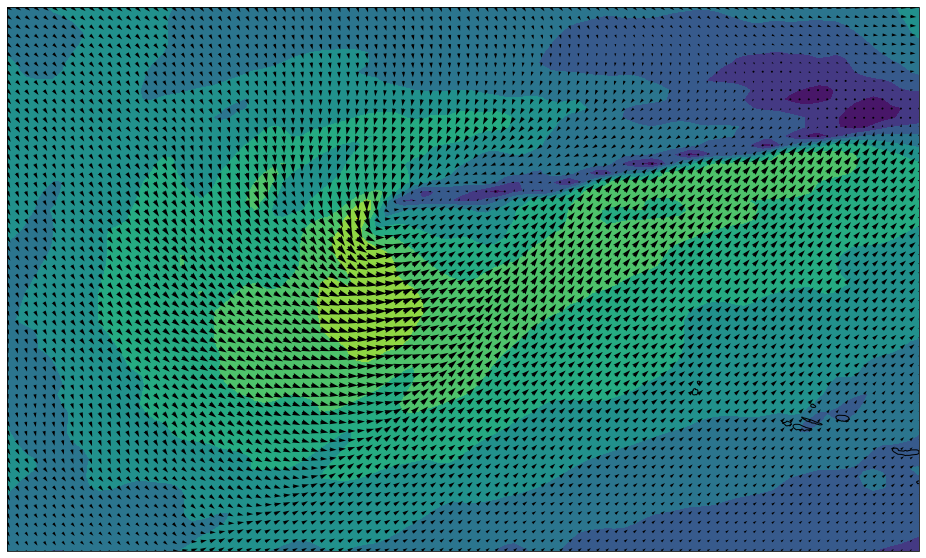

In [3]:
DATE = "20201101"
POSSIBLE_HOURS = ["00", "06", "12", "18"]
HOUR = "00"
MIN_LATITUDE, MAX_LATITUDE = 35, 50
MIN_LONGITUDE, MAX_LONGITUDE = 310, 335

# Load data
wind_data = xr.open_dataset(f"../data/remss/202011/CCMP_RT_Wind_Analysis_{DATE}_V02.1_L3.0_RSS.nc")
# Filter on time
selected_dt = f"{dt.strptime(DATE, '%Y%m%d').strftime('%Y-%m-%d')}T{HOUR}:00:00"
wind_data = wind_data.sel(time = slice(selected_dt, selected_dt)).mean('time')
# Filter on position
latidx = (wind_data['latitude'] >= MIN_LATITUDE) & (wind_data['latitude'] <= MAX_LATITUDE) 
lonidx = (wind_data['longitude'] >= MIN_LONGITUDE) & (wind_data['longitude'] <= MAX_LONGITUDE)
# Get positions and wind speed
lon = wind_data['longitude'][lonidx]
lat = wind_data['latitude'][latidx]
u = wind_data['uwnd'][latidx, lonidx]
v = wind_data['vwnd'][latidx, lonidx]
wind_speed = np.sqrt(u**2 + v**2)

# Plot data
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.contourf(lon, lat, wind_speed, transform=ccrs.PlateCarree())
ax.quiver(lon, lat, u, v)
ax.coastlines()
plt.show()

## Params

In [4]:
lon_step = (lon[1].values - lon[0].values)
lat_step = (lat[1].values - lat[0].values)

### Identify Vortex center

In [5]:
# TODO: try using combined methods: convolve to blur the data and rotational !

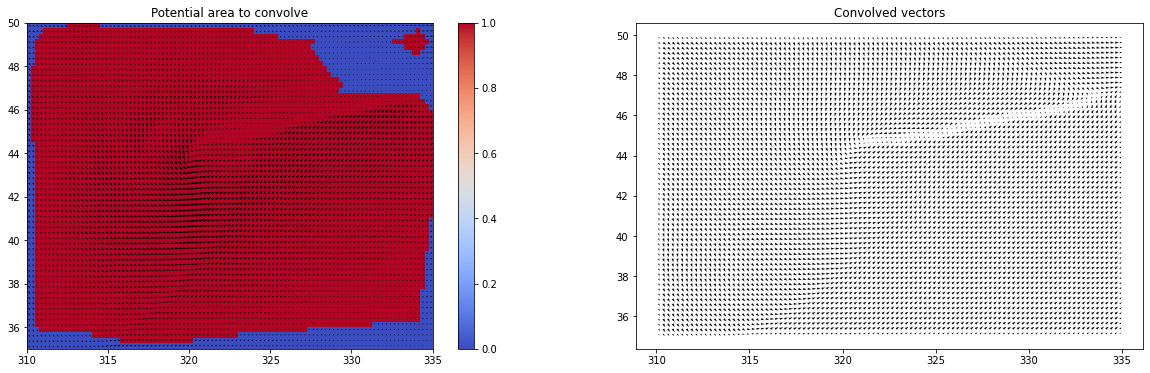

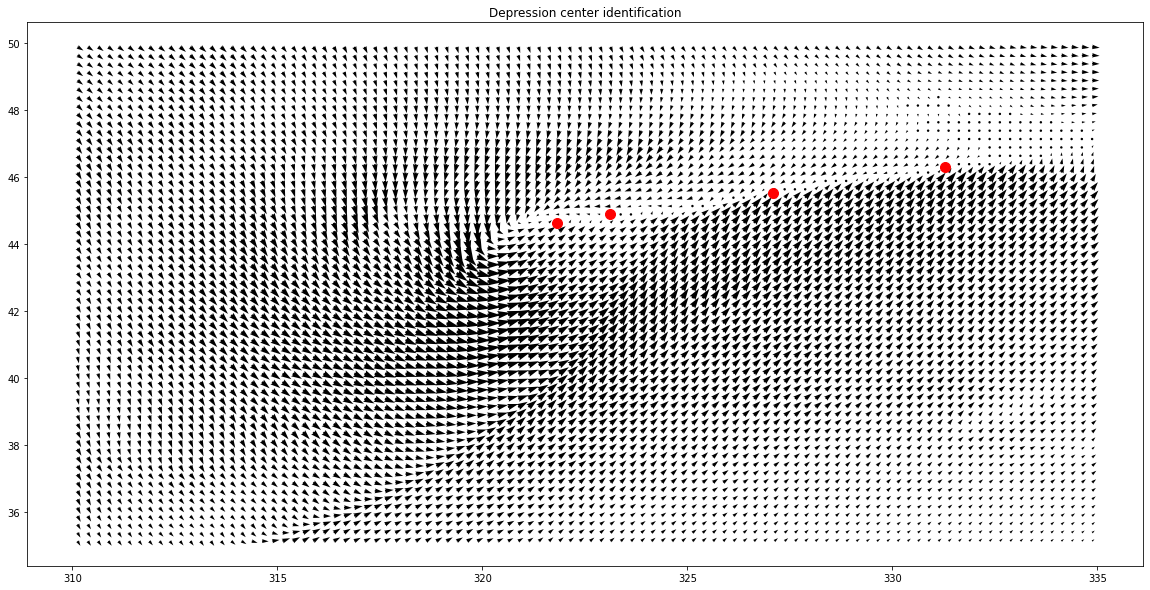

In [8]:
# Identify vortex centers 
method = "convolution" # Among 'rotational', 'convolution'
plot = True
if method == "convolution":
    lon_centers, lat_centers = identify_vortex_centers_using_convolution(lon, lat, u, v, plot=plot)
elif method == "rotational":
    lon_centers, lat_centers = identify_vortex_centers_with_rot(lon, lat, u, v, plot=plot)


# Plot
plt.figure(figsize=(20, 10))
plt.quiver(lon, lat, u, v, units="xy")
plt.scatter(lon_centers, lat_centers, color="red", s=100)
plt.title("Depression center identification")
plt.show()

### Identify Vortex radius

In [28]:
# TODO: try radius on different angles (multiples de pi / 8)

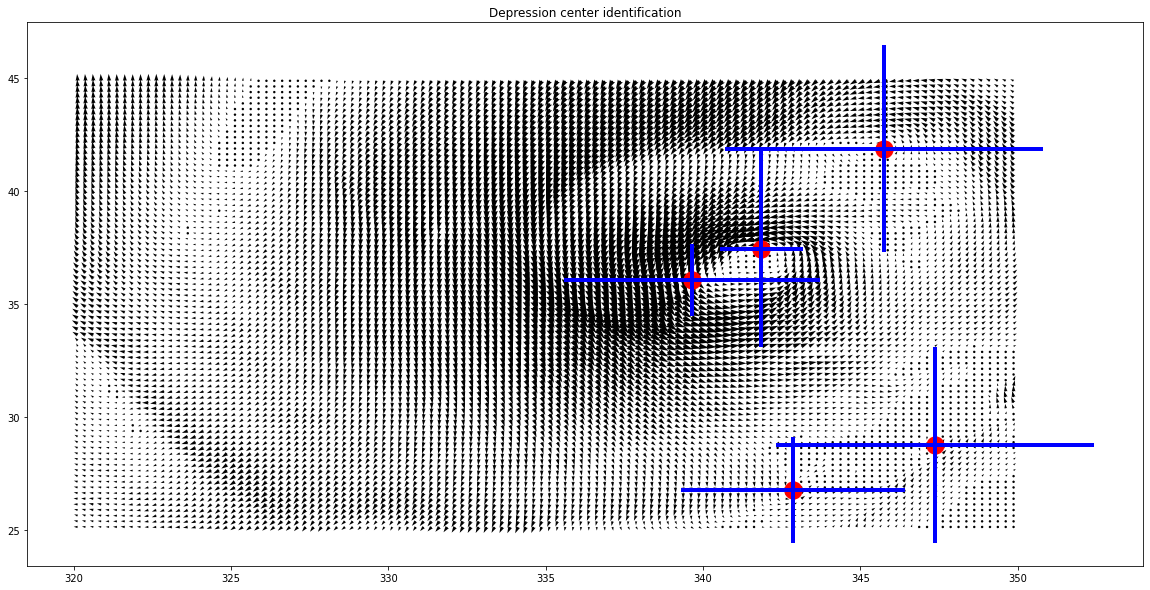

In [29]:
# Identify vortex radius
radius_long, radius_lat = identify_vortex_radius(lon_centers, lat_centers, lon, lat, u, v, n_iterations=20)

# Prepare radius plots
plot_lon_radius, plot_lat_radius = [], []
for i, (rad_lon, rad_lat) in enumerate(zip(radius_long, radius_lat)):
    plot_lon_radius.append([lon_centers[i] + k * lon_step for k in range(-rad_lon, rad_lon+1)])
    plot_lat_radius.append([lat_centers[i] + k * lat_step for k in range(-rad_lat, rad_lat+1)])

# Plot
plt.figure(figsize=(20, 10))
plt.quiver(lon, lat, u, v, units="xy")
plt.scatter(lon_centers, lat_centers, color="red", s=300)
for i, (plot_lon, plot_lat) in enumerate(zip(plot_lon_radius, plot_lat_radius)):
    plt.plot(plot_lon, [lat_centers[i]] * len(plot_lon), color="blue", linewidth=4)
    plt.plot([lon_centers[i]] * len(plot_lat), plot_lat, color="blue", linewidth=4)
plt.title("Depression center identification")
plt.show()


## Identify Vortex orientation

In [8]:
# TODO: using rotational

## Whole identification from meshgrid

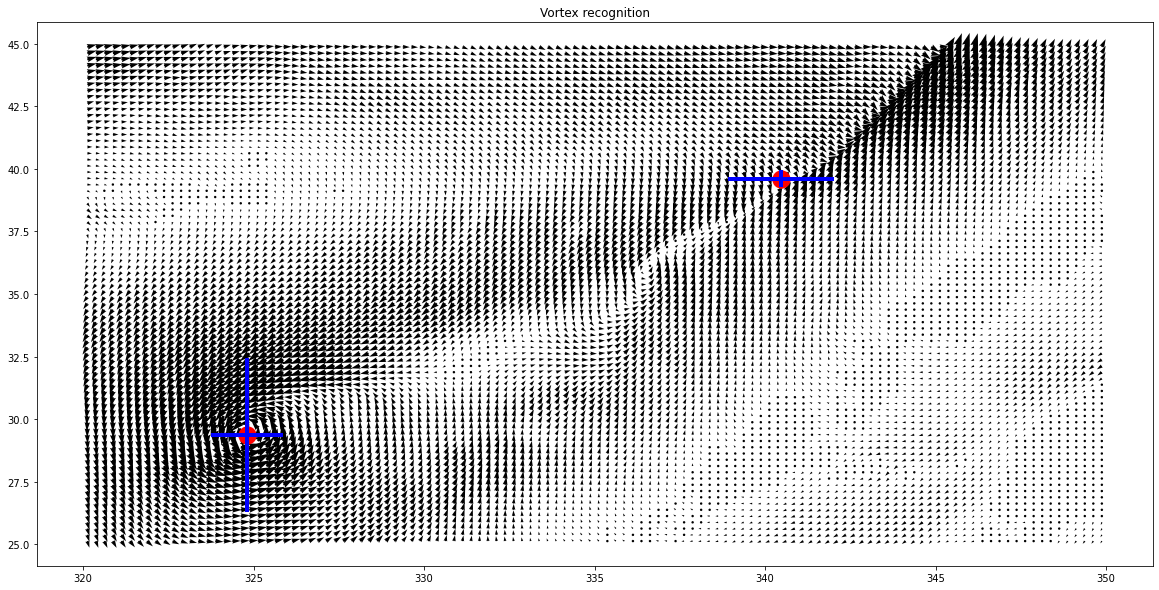

In [7]:
# Identify vortexes on map
vortexes = identify_vortex_parameters(lon, lat, u, v, center_method="rotational", n_radius_iterations=20)

# Prepare plot
lon_centers = [vortex.center.x for vortex in vortexes]
lat_centers = [vortex.center.y for vortex in vortexes]
plot_lon_radius, plot_lat_radius = [], []
for vortex in vortexes:
    plot_lon_radius.append([vortex.center.x + k * lon_step for k in range(-vortex.radius.x, vortex.radius.x + 1)])
    plot_lat_radius.append([vortex.center.y + k * lat_step for k in range(-vortex.radius.y, vortex.radius.y + 1)])

# Plot vortexes
plt.figure(figsize=(20, 10))
plt.quiver(lon, lat, u, v, units="xy")
plt.scatter(lon_centers, lat_centers, color="red", s=300)
for (vortex, plot_lon, plot_lat) in zip(vortexes, plot_lon_radius, plot_lat_radius):
    plt.plot(plot_lon, [vortex.center.y] * len(plot_lon), color="blue", linewidth=4)
    plt.plot([vortex.center.x] * len(plot_lat), plot_lat, color="blue", linewidth=4)
plt.title("Vortex recognition")
plt.show()

## Dev

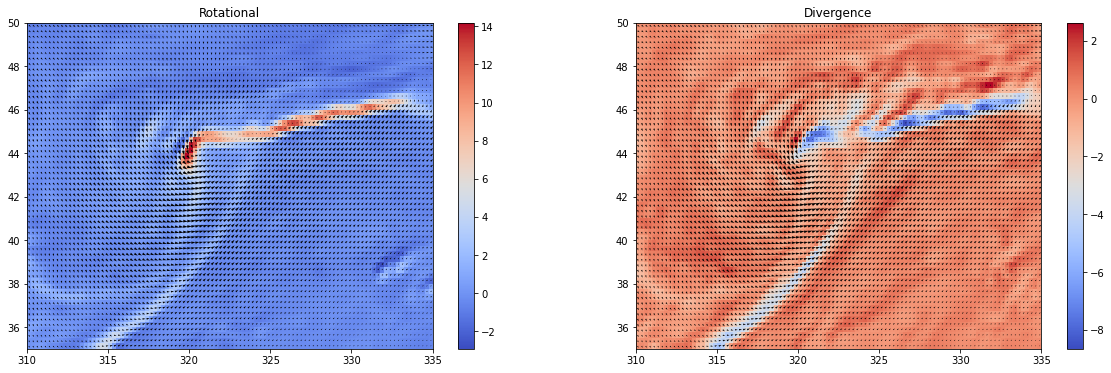

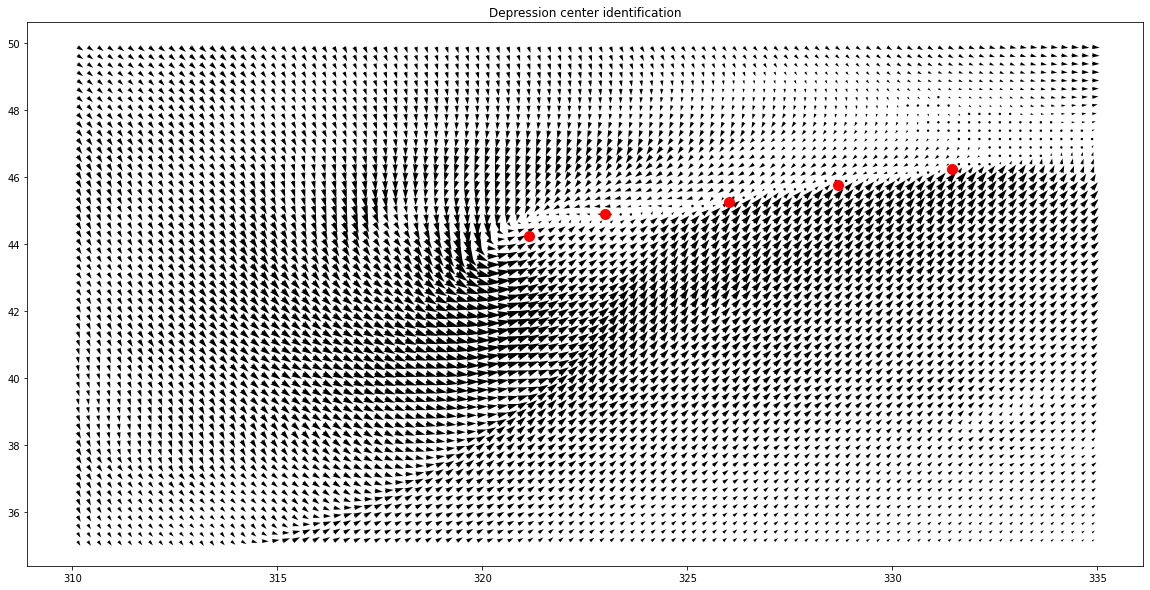

In [9]:
# Identify vortex centers 
method = "rotational" # Among 'rotational', 'convolution', 'combined'
plot = True
if method == "convolution":
    lon_centers, lat_centers = identify_vortex_centers_using_convolution(lon, lat, u, v, plot=plot)
elif method == "rotational":
    lon_centers, lat_centers = identify_vortex_centers_with_rot(lon, lat, u, v, plot=plot)

# Plot
plt.figure(figsize=(20, 10))
plt.quiver(lon, lat, u, v, units="xy")
plt.scatter(lon_centers, lat_centers, color="red", s=100)
plt.title("Depression center identification")
plt.show()

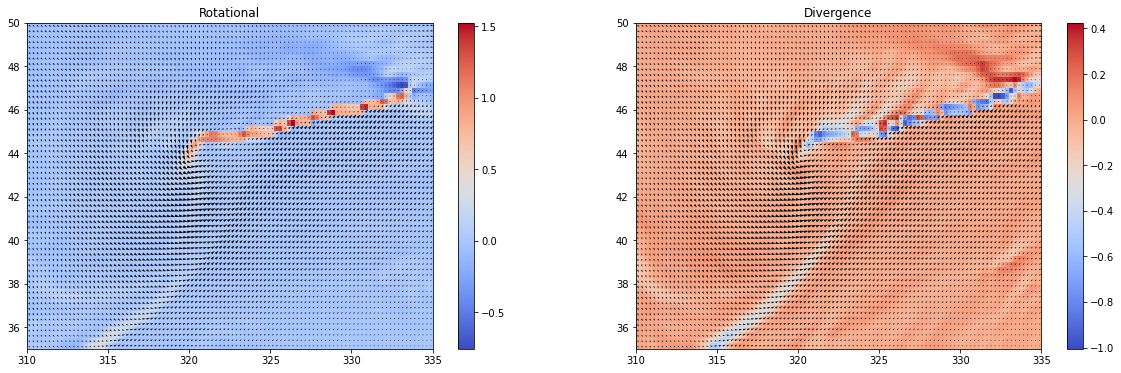

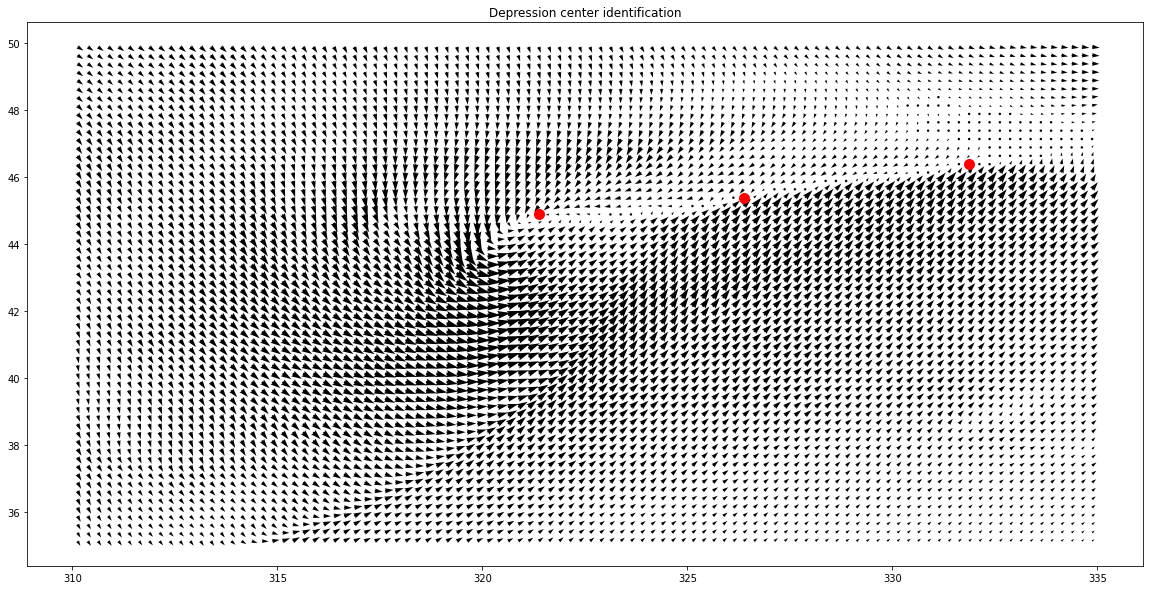

In [7]:
# Identify vortex centers 
method = "rotational" # Among 'rotational', 'convolution', 'combined'
lon_centers, lat_centers = identify_vortex_centers_with_combined(lon, lat, u, v, kernel_size=1, plot=True)

# Plot
plt.figure(figsize=(20, 10))
plt.quiver(lon, lat, u, v, units="xy")
plt.scatter(lon_centers, lat_centers, color="red", s=100)
plt.title("Depression center identification")
plt.show()

In [25]:
def plot_grad(lon, lat, grad_u, grad_v):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.title("Grad u")
    plt.pcolormesh(lon, lat, grad_u, shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
    plt.colorbar()
    plt.quiver(lon, lat, u, v)
    plt.subplot(1, 2, 2)
    plt.title("Grad v")
    plt.pcolormesh(lon, lat, grad_v, shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
    plt.colorbar()
    plt.quiver(lon, lat, u, v)

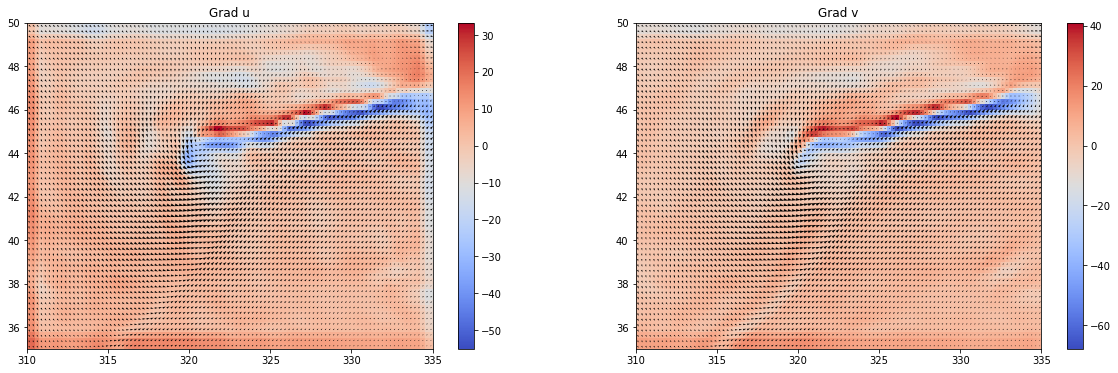

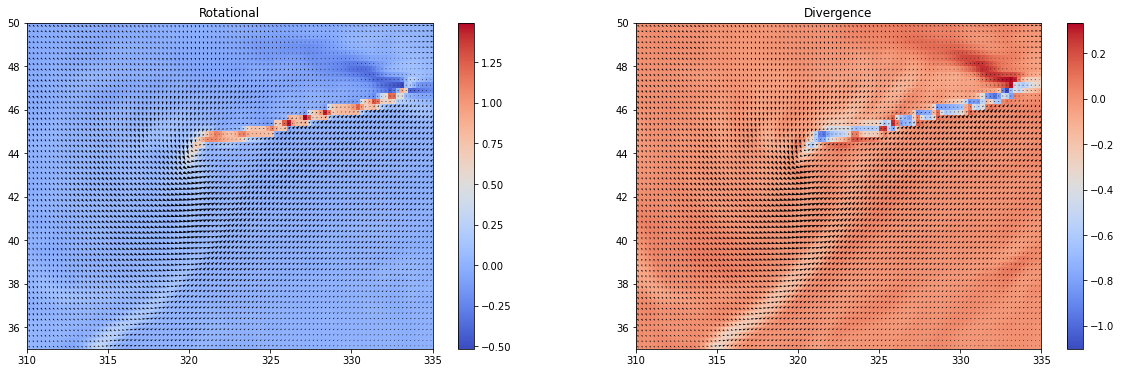

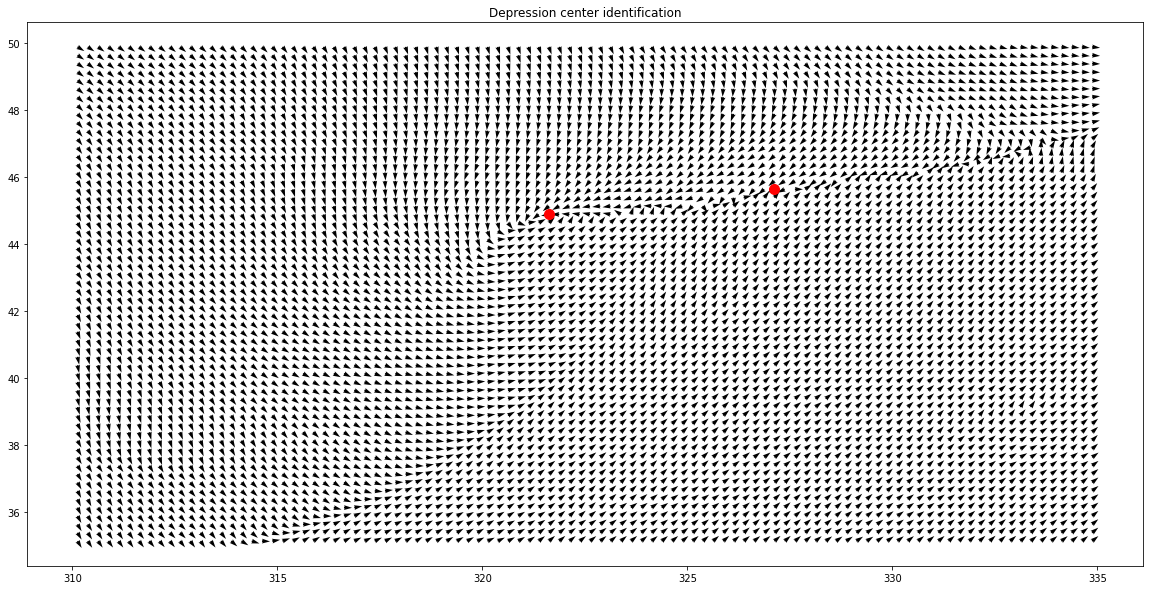

In [30]:
kernel = get_cross_matrix(5)

u_tmp, v_tmp = u.copy(), v.copy()

# Convolve vectors
u_tmp, v_tmp = convolve_vectors(vectors=[u_tmp, v_tmp], kernel=kernel)
wind_speed = np.sqrt(u_tmp**2+v_tmp**2)
plot_grad(lon, lat, np.gradient(wind_speed)[1] + np.gradient(wind_speed)[0], np.gradient(wind_speed)[0])
# Normalize vectors
u_tmp, v_tmp = normalize_vectors(u_tmp, v_tmp)
# Calculate wind vector rotational & divergence
rot_wind = calculate_rotational2d(u_tmp, v_tmp)
div_wind = calculate_divergence2d(u_tmp, v_tmp)
plot_rotational_and_divergence(lon, lat, rot_wind, div_wind)
# Identify potential candidates
candidates = get_candidates_rot(lon, lat, rot_wind, div_wind)
# Get centers from candidates
lon_centers, lat_centers = get_centers_from_potential_area_rot(candidates, deg_threshold=2)

# Plot
u_norm, v_norm = normalize_vectors(u, v)
plt.figure(figsize=(20, 10))
plt.quiver(lon, lat, u_norm, v_norm, units="xy")
plt.scatter(lon_centers, lat_centers, color="red", s=100)
plt.title("Depression center identification")
plt.show()